## Lab on real-world graph analysis

The objective of this lab is to get a feeling of real-world graphs.

## Import

In [1]:
import platform
platform.python_version()

'3.12.8'

In [2]:
import numpy as np

In [3]:
import networkx as nx

In [4]:
import matplotlib.pyplot as plt
from itertools import groupby

In [5]:
import sknetwork as skn

In [6]:
# Util function to plot the inverse cumulative distribution
def ccdf(values):
    x = []
    y = []
    values = sorted(values)

    # First make dist
    dist = [(key, len(list(group))) for key, group in groupby(values)]

    # Then compute inverse cumulative
    total = 1.0
    for (val, count) in dist:
        x.append(val)
        y.append(total)
        total -= count/len(values)
    return x, y


# Util function to return the distribution of values
def dist(values):
    values = sorted(values)

    # First make dist
    dist = [(key, len(list(group))) for key, group in groupby(values)]
    
    return [x[0] for x in dist], [x[1] for x in dist]

ccdf(values) - Fonction pour tracer la distribution cumulative inverse (CCDF)
La fonction ccdf calcule la distribution cumulative inverse d'un ensemble de valeurs. La distribution cumulative inverse (CCDF) est la complémentaire de la fonction de répartition cumulative (CDF). C'est-à-dire qu'au lieu de calculer la probabilité que les valeurs soient inférieures ou égales à une certaine valeur, on calcule la probabilité que les valeurs soient supérieures à une certaine valeur.

La fonction dist calcule la distribution simple des valeurs, c'est-à-dire le nombre d'occurrences de chaque valeur dans la liste donnée. Contrairement à ccdf, cette fonction calcule simplement la fréquence brute de chaque valeur

## Load data

We will work on 2 graphs induced by the [Vital articles of Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4), a selection of about 10,000 articles of the English Wikipedia:
* the directed graph of hyperlinks between these articles,
* the bipartite graph between articles and (stemmed) words used in their summary.

In [7]:
data = skn.data.load_netset('wikivitals')
data.keys()

Parsing files...
Done.


dict_keys(['adjacency', 'biadjacency', 'labels', 'labels_hierarchy', 'meta', 'names', 'names_col', 'names_labels', 'names_labels_hierarchy'])

In [8]:
# graph of links
adjacency = data.adjacency

In [9]:
# graph of words
biadjacency = data.biadjacency


In [10]:
# article names
names = data.names
names

array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
      dtype='<U62')

In [11]:
# article categories
categories = data.names_labels
categories

array(['Arts', 'Biological and health sciences', 'Everyday life',
       'Geography', 'History', 'Mathematics', 'People',
       'Philosophy and religion', 'Physical sciences',
       'Society and social sciences', 'Technology'], dtype='<U30')

In [12]:
# words
words = data.names_col
words

array(['Alexis', 'Cairo', 'subordinate', ..., 'parody', 'martyrdom',
       'Wyler'], dtype='<U26')

In [13]:
node_index = {name:i for i, name in enumerate(names)}

In [14]:
n_articles, n_words = biadjacency.shape

In [15]:
labels = data.labels


### Basic statistics

* Compute the number of nodes and edges for each of the two Wikivitals graph

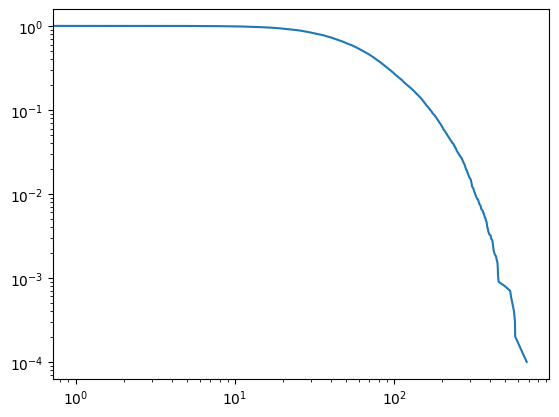

In [16]:
degrees = [ len(adjacency.indices[ adjacency.indptr[x]: adjacency.indptr[x+1]]) for x in range(adjacency.shape[0])] 

nbr_nodes=len(degrees)
nbr_edges=sum(degrees[i] for i in range(nbr_nodes))/2

x,y = ccdf(degrees)
plt.loglog(x, y)

### Degrees

* What are the minimum degree? The maximum one?
* Compute (and plot) the degree distribution of the WikiVitals graph, in log-log scale. For the `biadjacency`, you can plot separately the distributions for words and articles, and both together. Cumulative Complementary Distribution Function
* Based on these informations, how would you filter the graph before training it for a machine learning task? For example, you could imagine removing certain nodes.

In [17]:

min_degree = min(degrees)
max_degree = max(degrees)

print("Minimum degree:", min_degree)
print("Maximum degree:", max_degree)


Minimum degree: 0
Maximum degree: 680


D'après le graphe, il faudrait filtrer les nodes de degrè faible

Pour biparti :

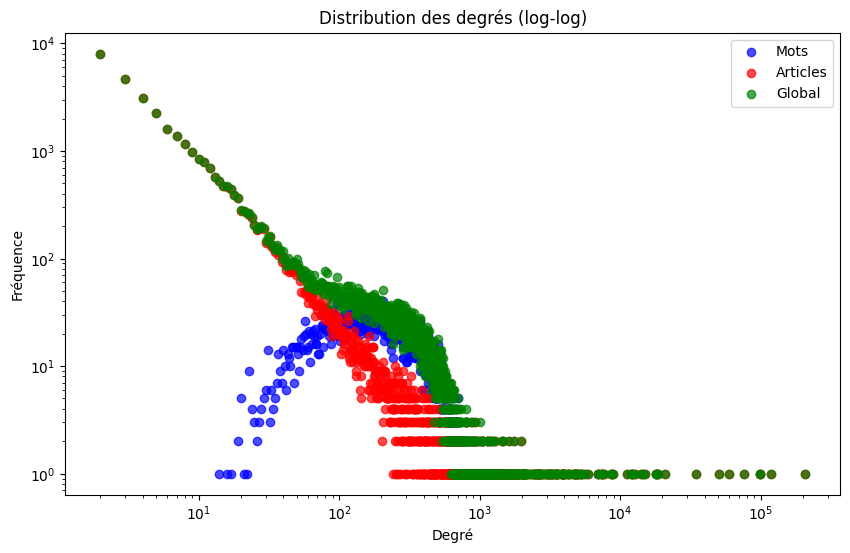

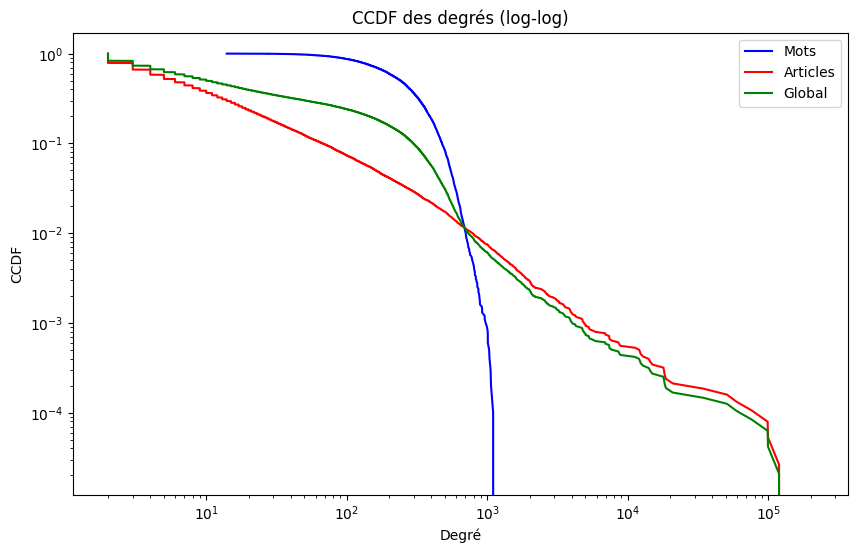

In [18]:

# Calcul des degrés
word_degrees = np.array(biadjacency.sum(axis=1)).flatten()  # Degrés des mots
article_degrees = np.array(biadjacency.sum(axis=0)).flatten()  # Degrés des articles

# Fonction pour tracer une distribution de degrés en log-log
def plot_degree_distribution(degrees, title, color):
    unique, counts = np.unique(degrees, return_counts=True)
    plt.scatter(unique, counts, label=title, color=color, alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degré")
    plt.ylabel("Fréquence")
    plt.legend()
    
# Tracer les distributions de degrés
plt.figure(figsize=(10, 6))
plot_degree_distribution(word_degrees, "Mots", "blue")
plot_degree_distribution(article_degrees, "Articles", "red")
plot_degree_distribution(np.concatenate([word_degrees, article_degrees]), "Global", "green")
plt.title("Distribution des degrés (log-log)")
plt.show()

# Fonction pour tracer la CCDF
def plot_ccdf(degrees, title, color):
    sorted_degrees = np.sort(degrees)
    ccdf = 1 - np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    plt.plot(sorted_degrees, ccdf, label=title, color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degré")
    plt.ylabel("CCDF")
    plt.legend()

# Tracer la CCDF
plt.figure(figsize=(10, 6))
plot_ccdf(word_degrees, "Mots", "blue")
plot_ccdf(article_degrees, "Articles", "red")
plot_ccdf(np.concatenate([word_degrees, article_degrees]), "Global", "green")
plt.title("CCDF des degrés (log-log)")
plt.show()


### Global density

* Compute the density of the Wikivitals graphs, before and after your filtering *(careful, one of the graphs is bipartite)*

In [19]:
d_min = 2*(np.mean(article_degrees)+np.mean(word_degrees))/2 # Seuil de degré minimum


biadjacent_density= biadjacency.nnz / (biadjacency.shape[0] * biadjacency.shape[1]) #Calcul de densité différent car graphe biparti 
print(f'Densité du graphe : {biadjacent_density}')

# Sélection des nœuds à conserver
words_to_keep = np.where(word_degrees >= d_min)[0]  # Indices des mots avec degré >= d_min
articles_to_keep = np.where(article_degrees >= d_min)[0]  # Indices des articles avec degré >= d_min

# Filtrer la matrice en gardant uniquement les nœuds sélectionnés
filtered_biadjacency = biadjacency[words_to_keep, :][:, articles_to_keep]

biadjacent_filtered_density = filtered_biadjacency.nnz / (filtered_biadjacency.shape[0] * filtered_biadjacency.shape[1])  # Densité de la matrice filtrée
print(f"Densité du graphe filtré : {biadjacent_filtered_density}")

Densité du graphe : 0.0035983697098207167
Densité du graphe filtré : 0.12530095228779634


In [20]:
# Supposons que adjacency est la matrice d'adjacence du graphe

num_nodes = adjacency.shape[0]  # Nombre de nœuds
num_edges = adjacency.nnz  # Nombre d'arêtes (valeurs non nulles dans la matrice d'adjacence)

# Densité du graphe
density = 2 * num_edges / (num_nodes * (num_nodes - 1))
print("Density before filtering:", density)

Density before filtering: 0.016465384580458


In [21]:
threshold = 2* np.mean(degrees)  # Seuil de degré
filtered_nodes = [i for i, degree in enumerate(degrees) if degree >= threshold]
filtered_adjacency = adjacency[filtered_nodes, :][:, filtered_nodes]
print(len(filtered_nodes), "nodes left after filtering")

1055 nodes left after filtering


In [22]:
degrees_filtered = [ len(filtered_adjacency.indices[ filtered_adjacency.indptr[x]: filtered_adjacency.indptr[x+1]]) for x in range(filtered_adjacency.shape[0])] 

num_nodes = filtered_adjacency.shape[0]  # Nombre de nœuds
num_edges = filtered_adjacency.nnz  # Nombre d'arêtes (valeurs non nulles dans la matrice d'adjacence)

density_filtered = 2 * num_edges / (num_nodes * (num_nodes - 1))
print("Density after filtering:", density_filtered)

Density after filtering: 0.18216138924611275


## Traversal

* Code a Breadth-First Search traversal
* Adapt your code to a Depth-First Search traversal
* Apply it to the two graphs

In [ ]:

def bfs(graph, source=None): # Breadth First Search : file
    """
    Parcours BFS dans un graphe représenté par une matrice CSR, sans utiliser deque.

    :param graph: Matrice d’adjacence au format CSR
    :param start_node: Noeud de départ
    :return: Dictionnaire {noeud: distance_depuis_start}
    """
    if source is None:
        source = np.random.choice(graph.shape[0])  # Choisir un nœud aléatoire si aucune source donnée
    
    visited = {source: 0}  # Distance depuis le point de départ
    queue = [source]  # File d’attente sous forme de liste
    front = 0  # Index pour éviter pop(0), optimisant l'accès en O(1)

    while front < len(queue):  # Simulation de file
        node = queue[front]
        front += 1  # Avancer le pointeur au lieu de modifier la liste
        current_distance = visited[node]

        try:
            neighbors = graph[node].indices  # Accéder aux voisins via CSR
        except:
            True

        for neighbor in neighbors:
            if neighbor not in visited:
                visited[int(neighbor)] = current_distance + 1
                queue.append(neighbor)  # Ajouter en fin de liste

    return visited


def dfs(graph, source=None): # Deep First Search : pile

    """
        Given a graph, returns a list of nodes corresponding to a
        Breadth-First search traversal. If source is None, pick a node randomly.
    """

    if source is None:
        source = np.random.choice(graph.shape[0])  # Choisir un nœud aléatoire si aucune source donnée
    
    visited = {source: 0}  # Distance depuis le point de départ
    queue = [source]  # File d’attente sous forme de liste

    while 0 < len(queue):  # Simulation de pile
        node = queue[-1]
        del(queue[-1])
        current_distance = visited[node]

        try:
            neighbors = graph[node].indices  # Accéder aux voisins via CSR
        except:
            True

        for neighbor in neighbors:
            if neighbor not in visited:
                visited[int(neighbor)] = current_distance + 1
                queue.append(neighbor)  # Ajouter en fin de liste

    return visited


bfs(filtered_biadjacency,0)
dfs(biadjacency,0)
# bfs(adjacency, 0)
# bfs(filtered_adjacency, 0)



{0: 0,
 969: 1,
 1462: 1,
 1645: 1,
 2304: 1,
 2485: 1,
 2791: 1,
 2991: 1,
 3853: 1,
 4461: 1,
 5692: 1,
 6447: 1,
 6856: 1,
 7794: 1,
 8543: 1,
 10261: 1,
 10727: 1,
 11596: 1,
 11662: 1,
 12071: 1,
 12946: 1,
 13740: 1,
 13833: 1,
 14265: 1,
 14751: 1,
 16486: 1,
 17621: 1,
 18038: 1,
 18616: 1,
 18725: 1,
 20295: 1,
 21237: 1,
 21372: 1,
 21573: 1,
 21690: 1,
 23876: 1,
 25594: 1,
 25682: 1,
 25817: 1,
 27061: 1,
 27282: 1,
 28367: 1,
 29595: 1,
 30079: 1,
 30187: 1,
 30509: 1,
 30529: 1,
 30877: 1,
 31190: 1,
 32032: 1,
 32263: 1,
 32643: 1,
 33523: 1,
 33689: 1,
 33974: 1,
 35355: 1,
 35529: 1,
 35574: 1,
 35590: 1,
 36142: 1,
 36262: 1,
 36766: 1,
 130: 2,
 145: 2,
 604: 2,
 633: 2,
 697: 2,
 737: 2,
 1120: 2,
 1150: 2,
 1322: 2,
 1482: 2,
 1668: 2,
 1808: 2,
 1864: 2,
 1926: 2,
 2200: 2,
 2398: 2,
 2701: 2,
 2911: 2,
 2992: 2,
 3245: 2,
 3283: 2,
 3471: 2,
 3516: 2,
 3768: 2,
 4449: 2,
 4535: 2,
 4904: 2,
 4982: 2,
 5107: 2,
 5545: 2,
 5577: 2,
 5691: 2,
 5743: 2,
 6172: 2,
 63

## PageRank

The [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm can be used to recommend nodes (here articles) close to some target.

## To do 

Using the 2 graphs (links, words):
* List the 10 articles the closest to some target of your choice (e.g., Vincent van Gogh).
* For the word graphs, list the 10 closest words of this target.
* Do the same with multiple targets.

In [24]:
pr = skn.ranking.PageRank()

In [25]:
target = node_index['Vincent van Gogh']
seed={target:1}

In [26]:
scores=pr.fit(adjacency, seed).scores_
top_5 = np.argsort(scores)[::-1][:5] #np.argsort trie les indices par rapport aux arguments, [::-1] pour trier dans l'ordre décroissant et [:5] pour prendre les 5 premiers
for node in top_5:
    print(names[node], scores[node])


Vincent van Gogh 0.15157772226205493
World War I 0.0037918970730890724
Metropolitan Museum of Art 0.003745495719839099
Impressionism 0.0037303490403393603
Pablo Picasso 0.003511538701961018


## Community detection

## To do

For the 2 graphs:
* Cluster the graph.
* Display the 5 most important nodes of each cluster (in terms of PageRank).
* Evaluate the quality of the clustering using the categories as ground-truth.

In [27]:
from sklearn.metrics import adjusted_rand_score as ari
from sknetwork.clustering import Louvain
import scipy.sparse as sp
import sknetwork

In [28]:
louvain = skn.clustering.Louvain()


In [29]:
labels = louvain.fit(adjacency,False).scores_#true en dernier argument si le graphe est biparti
print(labels)


TypeError: No matching signature found

In [ ]:
ari(labels, louvain.labels_)

InvalidParameterError: The 'labels_pred' parameter of adjusted_rand_score must be an array-like. Got None instead.

## Optional MovieLens: Load data

We will focus on the MovieLens dataset, a dataset of users rating movies. You can download its [graph version](). Regarding [networkx](), it is one of the most common graph libraries in Python. You can check the [documentation](), or ask me. 

In [ ]:
import networkx as nx
def load_data(filepath):
    
    edges = []
    
    for line in open(filepath):
        contents = line.split("::")
        user = "U-" + contents[0]
        movie = "M-" + contents[1]
        rating = contents[2]
        edges.append((user, movie))
    return nx.Graph(edges)

# Convention here: all "user" nodes start with "U-", all movie nodes start with "M-"
graph = load_data("ml-1m/ratings.dat")

FileNotFoundError: [Errno 2] No such file or directory: 'ml-1m/ratings.dat'

In [ ]:
# Convention here: all "user" nodes start with "U-", all movie nodes start with "M-"
graph = load_data("ml-1m/ratings.dat")

## To do

* What it the average rating? The ratings distribution?
* Does a rating prediction task make sense in this setting? Can you imagine a learning task that would be relevant on this data?
* What are the most important users? Movies?
* Try using the graph structure to predict adequate movies given a user's past ratings; you can try implementing first a very simple baseline (for example, predict the average rating for everyone), so that you have a point of comparison. You can then get more creative, and use, for examplem degrees, PageRank scores, clustering, as potential features for the rating prediction task.